In [1]:
# !pip install agentpy pytransform3d IPython seaborn
# !conda install -y scipy joblib pandas

import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, cdist
import scipy.stats as ss
import scipy.optimize as sio
import agentpy as ap
import matplotlib.pyplot as plt
import IPython
import random
import pytransform3d.plot_utils as p3d
from pytransform3d.transformations import translate_transform
import pandas as pd

plt.rc('animation', embed_limit=50)

%matplotlib widget

rng = np.random.default_rng(12345)
random.seed(12345)

In [2]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [3]:
class AircraftAgent(ap.Agent):
    def setup(self):
        self.max_vel = 205
        self.path = []

    def setup_fail(self, fail_prob):
        self.fail_prob = fail_prob
        self.failed = False

    def setup_pos(self, space: ap.Space):
        self.space = space
        self.neighbors = space.neighbors
        self.position = space.positions[self]

    def setup_goal(self, space: ap.Space, goal=np.array([0, 0, 0])):
        self.goal = goal
        self.path.append(goal)
        self.path_idx = 0

    def update(self):
        if random.random() < self.fail_prob and not self.failed:
            self.failed = True
            self.position[2] = 100
            for p in self.path:
                p[2] = 100
            self.space.move_to(self, self.position)
            return
        sub_goal = self.path[self.path_idx]
        vec_to_goal = sub_goal - self.position
        step_to_goal = normalize(vec_to_goal) * self.max_vel
        if (np.linalg.norm(step_to_goal) > np.linalg.norm(vec_to_goal)):
            try:
                self.space.remove_agents([self])
                self.model.agents.remove(self)
            except KeyError:
                pass
            return
        new_pos = self.position + step_to_goal
        self.position = new_pos
        self.space.move_to(self, new_pos)

In [4]:
class LimaModel(ap.Model):
    def setup(self):
        self.shape = np.array([self.p.xy_size, self.p.xy_size, self.p.z_size])
        self.space = ap.Space(self, shape=self.shape)
        self.total_volume = self.p.xy_size * self.p.xy_size * self.p.z_size
        self.exp_volume = np.power(self.p.xy_size * 0.8, 2) * np.pi * self.p.z_size / 4
        self.start_pop = int(np.ceil(self.total_volume * self.p.target_density))
        self.exp_n_agents = 0
        self.agents = ap.AgentList(self, self.start_pop, AircraftAgent)
        #         lanes = [self.get_random_lane() for agent in self.agents]
        start_pos = [rng.random(3) * self.shape for _ in self.agents]
        self.space.add_agents(self.agents, positions=start_pos)
        self.agents.setup_pos(self.space)
        self.agents.setup_fail(self.p.fail_prob)
        for agent, start in zip(self.agents, start_pos):
            goal = self.make_goal_pos(start)
            agent.setup_goal(self.space, goal)

        self.xy_sep_maxs = []
        self.z_sep_maxs = []
        self.xy_sep_means = []
        self.z_sep_means = []
        self.xy_sep_mins = []
        self.z_sep_mins = []
        self.tfc_dens = []
        self.conflict_counts = []
        self.pop = []

        self.prev_conflict_idxs = np.array([])

    def step(self):
        self.agents.update()

        # actual_total_density = len(self.space.agents)/self.total_volume
        if self.tfc_dens[-1] > self.p.target_density:
            return

        density_diff = self.p.target_density - self.tfc_dens[-1]
        req_agents = int(density_diff * self.exp_volume) * 2

        # if len(self.space.agents) < (self.start_pop + ss.norm(0, 5).rvs()):
        for _ in range(req_agents):
            new_agent = AircraftAgent(self)
            self.agents.append(new_agent)
            self.space.add_agents([new_agent], [rng.random(3) * self.shape])
            new_agent.setup_pos(self.space)
            new_agent.setup_goal(self.space, rng.random(3) * self.shape)
            new_agent.setup_fail(self.p.fail_prob)

    def update(self):
        exp_positions = self.filter_exp_positions(self.space.agents.position)
        self.exp_n_agents = len(exp_positions)
        # print(self.exp_n_agents)

        if self.exp_n_agents < 2:
            self.end()
            return

        # Separations
        xy_seps = pdist(exp_positions[:, :2], 'cityblock')
        z_seps = pdist(np.vstack((exp_positions[:, 2], np.zeros(exp_positions.shape[0]))).T, 'cityblock')
        # assert xy_seps.shape[0] == z_seps.shape[0]
        # xy_seps = xy_seps[xy_seps > 0.0]  # Remove distance from self
        # z_seps = z_seps[z_seps > 0.0]  # Remove distance from self
        # assert xy_seps.shape[0] == z_seps.shape[0]
        self.record('Mean XY Sep', xy_seps.mean())
        self.record('Mean Z Sep', z_seps.mean())
        self.record('Min XY Sep', xy_seps.min())
        self.record('Min Z Sep', z_seps.min())
        self.record('Max XY Sep', xy_seps.max())
        self.record('Max Z Sep', z_seps.max())
        xy_conflicts = xy_seps < self.p.conflict_xy_dist
        z_conflicts = z_seps < self.p.conflict_z_dist
        conflicts = np.logical_and(xy_conflicts, z_conflicts)
        # conflict_idxs = np.nonzero(conflicts)
        # repeated_conflicts = np.logical_and(conflict_idxs, self.prev_conflict_idxs)
        # if repeated_conflicts.sum() > 0:
        #     print('Avoided repeated conflict')
        # self.prev_conflict_idxs = conflict_idxs
        self.record('Instant Conflict Counts', conflicts.sum())#-repeated_conflicts.sum())
        self.record('Instant Population', self.exp_n_agents)

        self.xy_sep_maxs += [xy_seps.max()]
        self.z_sep_maxs += [z_seps.max()]
        self.xy_sep_mins += [xy_seps.min()]
        self.z_sep_mins += [z_seps.min()]
        self.xy_sep_means += [xy_seps.mean()]
        self.z_sep_means += [z_seps.mean()]
        self.tfc_dens += [self.exp_n_agents / self.exp_volume]
        self.pop += [self.exp_n_agents]

        # Traffic Densities
        self.record('Traffic Density', self.exp_n_agents / self.exp_volume)
        # print('tfc density ', self.exp_n_agents / self.exp_volume)

    def end(self):
        self.report('Min XY Sep', np.array(self.xy_sep_mins).min())
        self.report('Min Z Sep', np.array(self.z_sep_mins).min())
        self.report('Mean XY Sep', np.array(self.xy_sep_means).mean())
        self.report('Mean Z Sep', np.array(self.z_sep_means).mean())
        self.report('Max XY Sep', np.array(self.xy_sep_maxs).max())
        self.report('Max Z Sep', np.array(self.z_sep_maxs).max())
        self.report('Max Traffic Density', np.array(self.tfc_dens).max())
        self.report('Min Traffic Density', np.array(self.tfc_dens).min())
        self.report('Mean Traffic Density', np.array(self.tfc_dens).mean())
        self.report('Mean Instant Conflict Count', np.array(self.conflict_counts).mean())
        self.report('Sum Instant Conflict Count', np.array(self.conflict_counts).sum())
        self.report('Mean Population', np.array(self.pop).mean())

    def get_random_lane(self):
        return random.choice(self.p.lanes)

    def make_goal_pos(self, start):
        xy_goal = np.array(rng.random(2)*self.p.xy_size)
        dist = np.linalg.norm(xy_goal-start[:2])
        # climb_or_descend = rng.random() > 0.5
        vert_dist = dist*np.sin(np.radians(self.p.vert_angle))
        vert_distr = ss.uniform(loc=-vert_dist, scale=2*vert_dist)
        # z_goal = start[2]+vert_dist if climb_or_descend else start[2]-vert_dist
        z_goal = vert_distr.rvs()
        return np.hstack([xy_goal, z_goal])

    def filter_exp_positions(self, positions):
        positions = np.array(positions)
        midpoint = np.array([self.p.xy_size // 2, self.p.xy_size // 2, self.p.z_size // 2])
        xy_distances = np.array([np.linalg.norm(pos[:2]-midpoint[:2]) for pos in positions])
        return positions[xy_distances < self.p.xy_size*0.4] # 80% diameter

In [19]:
params = {
    'xy_size': 1000000,
    'z_size': 1524,
    'target_density': 2.925e-14 / 0.23,
    # 'population': 200,
    'steps': 20000,
    'vert_angle': 5,
    'conflict_xy_dist': 12,
    'conflict_z_dist': 6,
    # 'spawn_rate': 10000,  #steps per spawn
    'fail_prob': 0.0,  # Failure probability of each agent at each timestep
}
model = LimaModel(params)
results = model.run()

Completed: 20000 steps
Run time: 0:01:04.929664
Simulation finished


C:\Users\Aliak\AppData\Local\Temp\ipykernel_10080\1568538853.py:106: RuntimeWarning: Mean of empty slice.
  self.report('Mean Instant Conflict Count', np.array(self.conflict_counts).mean())
C:\ANACON~1\envs\sandbox\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
df = results.variables.LimaModel.iloc[1000:, :]
df

,Mean XY Sep,Mean Z Sep,Min XY Sep,Min Z Sep,Max XY Sep,Max Z Sep,Instant Conflict Counts,Instant Population,Traffic Density
t,,,,,,,,,
1000,446233.001327,757.893741,3813.677248,0.0,1.087364e+06,1524.0,0,152,1.984215e-13
1001,446143.723827,757.895447,3743.048371,0.0,1.086973e+06,1524.0,0,152,1.984215e-13
1002,446054.626549,757.897153,3672.419574,0.0,1.086582e+06,1524.0,0,152,1.984215e-13
1003,445965.858700,757.898858,3601.790856,0.0,1.086192e+06,1524.0,0,152,1.984215e-13
1004,445877.395880,757.900564,3531.162218,0.0,1.085801e+06,1524.0,0,152,1.984215e-13
...,...,...,...,...,...,...,...,...,...
19996,461352.219410,741.144437,8747.124446,0.0,1.078187e+06,1524.0,0,98,1.279297e-13
19997,461353.163756,741.142462,8747.124446,0.0,1.078187e+06,1524.0,0,98,1.279297e-13
19998,461354.108101,741.140487,8747.124446,0.0,1.078187e+06,1524.0,0,98,1.279297e-13


In [21]:
df.describe()

,Mean XY Sep,Mean Z Sep,Min XY Sep,Min Z Sep,Max XY Sep,Max Z Sep,Instant Conflict Counts,Instant Population,Traffic Density
count,19001.000000,19001.000000,19001.000000,19001.0,1.900100e+04,19001.0,19001.0,19001.000000,1.900100e+04
mean,454325.615095,743.295196,7843.724638,0.0,1.079720e+06,1524.0,0.0,104.046419,1.358227e-13
std,14413.816206,3.379883,1926.893147,0.0,7.233402e+03,0.0,0.0,14.306074,1.867522e-14
min,399177.024813,732.315351,349.255356,0.0,1.052235e+06,1524.0,0.0,96.000000,1.253189e-13
25%,456108.821027,741.100851,8741.747284,0.0,1.078187e+06,1524.0,0.0,97.000000,1.266243e-13
50%,458579.213245,744.114262,8747.124446,0.0,1.078187e+06,1524.0,0.0,99.000000,1.292351e-13
75%,460807.901025,745.579499,8747.124446,0.0,1.078187e+06,1524.0,0.0,100.000000,1.305405e-13
max,472444.577793,757.929559,9907.649443,0.0,1.124740e+06,1524.0,0.0,154.000000,2.010323e-13


<AxesSubplot:xlabel='t', ylabel='Instant Conflict Counts'>

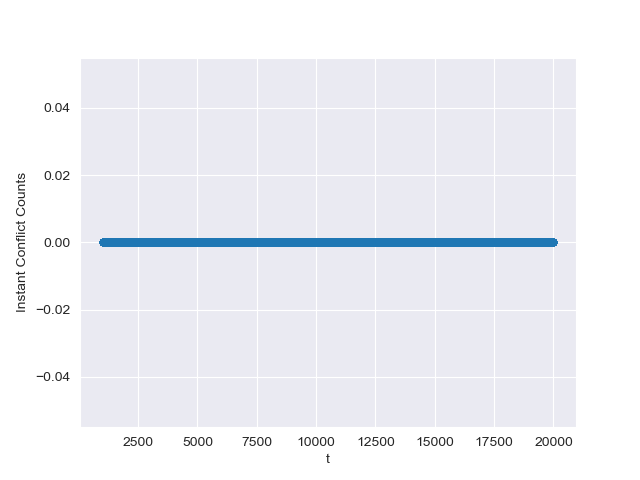

In [22]:
df.reset_index().plot('t', 'Instant Conflict Counts', kind='scatter')

In [23]:
conflict_sum = df['Instant Conflict Counts'].sum()
sim_hrs = df.index.max()/60
mean_col_rate = conflict_sum/ (sim_hrs)
print(f'Mean unmitigated collision rate {mean_col_rate} collisions per hour')

Mean unmitigated collision rate 0.0 collisions per hour


In [24]:
flyable_day_hrs = 9
flyable_hrs_year = flyable_day_hrs * 365
asp_vol = 1.5e11 * 304.8 * 5 # 5000ft x 150,000km^2, national airspace
lamba_tm = 0.1 # From Goodhart estimation
exp_col = mean_col_rate * flyable_hrs_year
print(f'Expected unmitigated collisions  up to 5000ft over a year {exp_col}')
print(f'Expected mitigated collisions up to 5000ft over a year {exp_col*lamba_tm:02f}')

Expected unmitigated collisions  up to 5000ft over a year 0.0
Expected mitigated collisions up to 5000ft over a year 0.000000


The average number of airproxes per year in the UK between VFR uncontrolled traffic is 68.4 over the period 2000-2022. Cornwall is a lower traffic density area, therefore the expected number of collisions is expected to be lower.

<AxesSubplot:xlabel='t', ylabel='Traffic Density'>

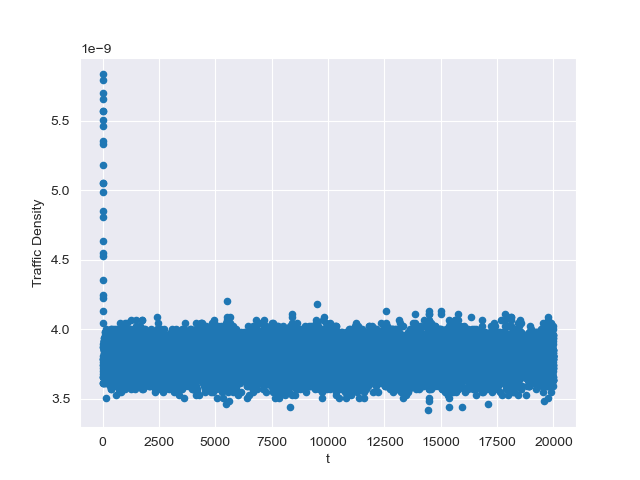

In [92]:
df.reset_index().plot('t', 'Traffic Density', kind='scatter')

In [9]:
param_ranges = {
    'xy_size': ap.IntRange(5000, 30000),
    'z_size': 914,
    'target_density': 4.1e-9,
    # 'population': 200,
    'steps': 20000,
    'vert_angle': 5,
    'conflict_xy_dist': 12,
    'conflict_z_dist': 6,
    # 'spawn_rate': 10000,  #steps per spawn
    'fail_prob': 0.0,  # Failure probability of each agent at each timestep
}
sample = ap.Sample(param_ranges, n=15)
exp = ap.Experiment(LimaModel, sample, record=True)
exp_results = exp.run(n_jobs=-1, verbose=20)

Scheduled runs: 15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    6.7s remaining:   43.3s
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:    6.9s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    7.0s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:   11.4s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:   31.1s remaining:   35.6s
/tmp/ipykernel_126719/2893545695.py:104: RuntimeWarning: Mean of empty slice.
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   44.6s remaining:   39.0s
/tmp/ipykernel_126719/28

ValueError: operands could not be broadcast together with shapes (1,2) (1,0) 

In [214]:
res = exp_results.arrange_reporters()
res

,sample_id,seed,Min XY Sep,Min Z Sep,Mean XY Sep,Mean Z Sep,Max XY Sep,Max Z Sep,Max Traffic Density,Min Traffic Density,Mean Traffic Density,Mean Instant Conflict Count,Sum Instant Conflict Count,Mean Population,xy_size
0,0,247133966082571016177747752929478944801,0.206901,0.0,2212.621793,277.103422,5636.582309,913.974224,6.181620e-09,2.960212e-09,3.971714e-09,NaN,0.0,45.617769,5000
1,1,231127184241152162670433155874736331088,0.451223,0.0,2879.183051,300.789812,7516.511902,913.995901,6.563842e-09,3.428873e-09,3.973253e-09,NaN,0.0,81.113444,6666
2,2,112404038273634113444575070198353390593,0.434814,0.0,3648.057270,296.280873,9415.385450,913.999579,6.488608e-09,3.573436e-09,3.991153e-09,NaN,0.0,127.326034,8333
3,3,140854354372256807706391504966940805477,0.264839,0.0,4288.751768,293.337318,11304.112897,914.000000,6.246919e-09,3.700265e-09,4.016849e-09,NaN,0.0,184.544673,10000
4,4,972325487273492275196023229639235831,0.235521,0.0,5113.960919,310.413845,13181.569537,914.000000,6.316299e-09,3.773788e-09,4.038366e-09,NaN,0.0,252.545773,11667
5,5,245523073721652547752789808318978446214,0.208107,0.0,5877.211599,308.412042,15070.254119,914.000000,5.999627e-09,3.832415e-09,4.038054e-09,NaN,0.0,329.794860,13333
6,6,335828647936523511588218129614520335935,0.229904,0.0,6593.538182,313.159222,16960.353136,914.000000,6.171946e-09,3.888906e-09,4.049890e-09,NaN,0.0,418.641018,15000
7,7,15512813936226881752284299881376588244,0.060692,0.0,7304.735640,311.468999,18845.022181,914.000000,6.088217e-09,3.925607e-09,4.060121e-09,NaN,0.0,518.167192,16667
8,8,102939251715798772849593911760988014218,0.151309,0.0,8085.650886,314.390660,20723.400823,914.000000,6.145196e-09,3.924119e-09,4.065565e-09,NaN,0.0,627.843458,18334
9,9,11613965391283151042455983706854748819,0.185672,0.0,8870.010124,318.994389,22619.115565,914.000000,5.920425e-09,3.956019e-09,4.067793e-09,NaN,0.0,747.540823,20000


In [213]:
exp_df = exp_results['variables']['LimaModel']
exp_df

Mean XY Sep  Mean Z Sep  Min XY Sep  Min Z Sep    Max XY Sep  \
sample_id t                                                                     
0         0      2278.941870  294.256800   37.205596   0.232239   5488.546586   
          1      2300.280366  291.706267   13.486063   0.078299   5353.959513   
          2      2334.968225  278.170413   18.971541   0.102836   5222.256799   
          3      2364.568848  257.117870   28.500305   0.090329   5513.592553   
          4      2344.434698  244.178175   15.184883   0.191967   5479.681816   
...                      ...         ...         ...        ...           ...   
9         19996  8851.861177  319.541376    7.263912   0.000000  22333.090510   
          19997  8866.346238  318.790168    6.651660   0.000000  22396.551473   
          19998  8881.708550  319.303865   23.618336   0.000000  22439.267319   
          19999  8862.748566  319.737943    9.034583   0.000000  22502.430730   
          20000  8854.402254  319.427318    8.633433   0.000000  22409.586489   

                  Max Z Sep  Instant Conflict Counts  Instant Population  \
sample_id t                                                                
0         0      893.234341                        0                  48   
          1      826.917308                        0                  55   
          2      781.303205                        0                  62   
          3      743.966759                        0                  67   
          4      776.798677                        0                  71   
...                     ...                      ...                 ...   
9         19996  914.000000                        0                 752   
          19997  914.000000                        0                 750   
          19998  914.000000                        0                 750   
          19999  914.000000                        0                 746   
          20000  914.000000                        0                 744   

                 Traffic Density  
sample_id t                       
0         0         4.179123e-09  
          1         4.788579e-09  
          2         5.398034e-09  
          3         5.833360e-09  
          4         6.181620e-09  
...                          ...  
9         19996     4.092058e-09  
          19997     4.081175e-09  
          19998     4.081175e-09  
          19999     4.059409e-09  
          20000     4.048526e-09  

[200010 rows x 9 columns]

                         Instant Conflict Counts   xy_size    volume  col_rate
Instant Conflict Counts                 1.000000  0.958859  0.963942 -0.119523
xy_size                                 0.958859  1.000000  0.986074 -0.297500
volume                                  0.963942  0.986074  1.000000 -0.341344
col_rate                               -0.119523 -0.297500 -0.341344  1.000000
Mean conflict rate 1.2477396859438993e-14


,Instant Conflict Counts,xy_size,volume,col_rate
0,4,5000,1.794635e+10,1.114433e-14
1,7,6666,3.189824e+10,1.097239e-14
2,18,8333,4.984698e+10,1.805526e-14
3,23,10000,7.178539e+10,1.601997e-14
4,21,11667,9.771348e+10,1.074570e-14
5,36,13333,1.276121e+11,1.410525e-14
6,30,15000,1.615171e+11,9.286941e-15
7,52,16667,1.994118e+11,1.303834e-14
8,47,18334,2.412962e+11,9.739066e-15
9,67,20000,2.871416e+11,1.166672e-14


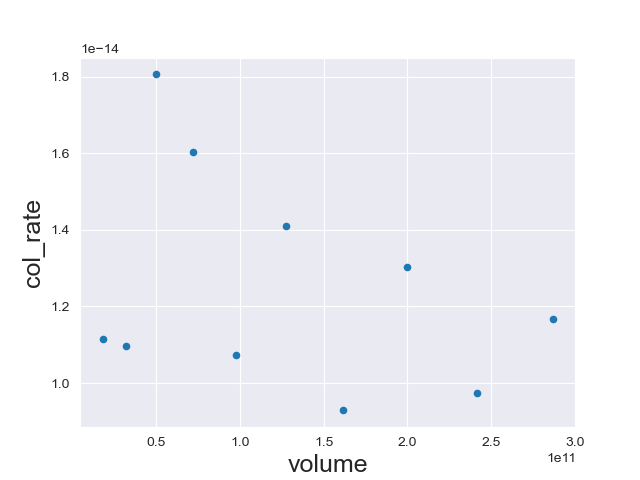

In [218]:
exp_conflicts = pd.concat([exp_df.groupby('sample_id')['Instant Conflict Counts'].sum(),res['xy_size']], axis=1)
exp_conflicts['volume'] = np.power(exp_conflicts['xy_size'],2) * np.pi * 0.25 * param_ranges['z_size']
exp_conflicts['col_rate'] = exp_conflicts['Instant Conflict Counts'] / (exp_conflicts['volume'] * params['steps'])
exp_conflicts.plot('volume', 'col_rate', kind='scatter')
print(exp_conflicts.corr())
print(f'Mean conflict rate {exp_conflicts["col_rate"].mean()}')
exp_conflicts

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:xlabel='Traffic Density', ylabel='Instant Population'>

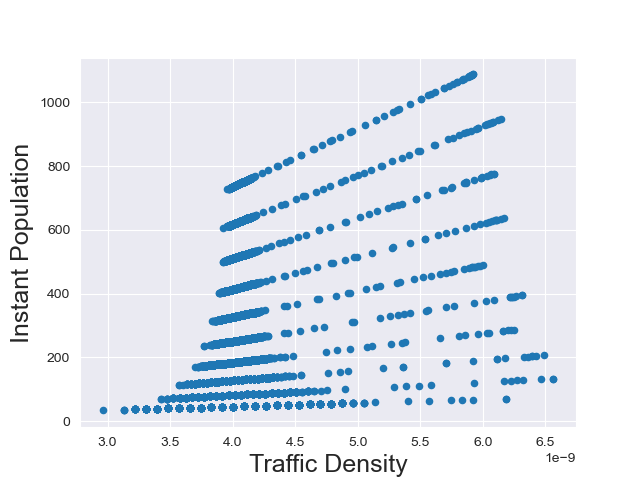

In [193]:
# exp_df = exp_results.reporters
exp_df.plot('Traffic Density', 'Instant Population', kind='scatter')

In [182]:
plt.rcParams["axes.labelsize"] = 18
plt.tight_layout()
sns.heatmap(exp_results.reporters.corr(), annot=True)

<AxesSubplot:>

In [ ]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse


def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 3
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        skyline = skyline.difference(to_drop)
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)


pareto_front = find_skyline_bnl(exp_df, to_min=[], to_max=['Mean Traffic Density', 'Min 3D Sep'])
# exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Mean Traffic Density')
exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Max Traffic Density', 'Min 3D Sep', c='r')
exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Max Traffic Density', 'Min 3D Sep', kind='scatter',
                                                              c='r')

In [ ]:
print(exp_df['Traffic Density'][exp_df['Traffic Density'] < exp_df['Traffic Density'].quantile(0.9)])
print(exp_df['Traffic Density'])

In [ ]:
exp_df.plot(x='Max Traffic Density', y='Min 3D Sep', kind='scatter', logx=True)

In [ ]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    pos = m.space.agents.position
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)


#     for lane in m.p.lanes:
#         ax.scatter(*lane[0], c='r')
#         ax.scatter(*lane[1], c='b')
#         half_height_start = lane[0][2]/2
#         start_atz_centre = np.array([lane[0][0], lane[0][1], half_height_start])
#         half_height_end = lane[1][2]/2
#         end_atz_centre = np.array([lane[1][0], lane[1][1], half_height_end])
#         p3d.plot_cylinder(ax=ax, wireframe=False, alpha=0.2, radius=20, length=lane[0][2], A2B=translate_transform(np.eye(4), start_atz_centre))
#         p3d.plot_cylinder(ax=ax, wireframe=False, alpha=0.2, radius=20, length=lane[1][2], A2B=translate_transform(np.eye(4), end_atz_centre))

#     ax.set_axis_off()

def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))